In [438]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
# !pip install xgboost
from xgboost import XGBClassifier


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from datetime import date
from sklearn.impute import KNNImputer

import datetime as dt



import warnings
warnings.filterwarnings("ignore")

# Objective of this case study is:

### Predict driver churn based on features like- demographics, tenure, performance of driver


In [439]:
df = pd.read_csv("car_rental_data.csv")

In [440]:
df.shape

(19104, 14)

In [441]:
df.head(5)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [442]:
df['Driver_ID'].nunique()

2381

# Data understanding and problem discussion

### we are given details of each driver: 
### demographics information: age/gender/citu/education
### tenure: dateOfJoining/lastDate
### historical data: Quarterly rating, Monthly business acquired (Total Business Value), grade, Income

### data dictionary:

    MMMM-YY : Reporting Date (Monthly)
    Driver_ID : Unique id for drivers
    Age : Age of the driver
    Gender : Gender of the driver – Male : 0, Female: 1
    City : City Code of the driver
    Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
    Income : Monthly average Income of the driver
    Date Of Joining : Joining date for the driver
    LastWorkingDate : Last date of working for the driver
    Joining Designation : Designation of the driver at the time of joining
    Grade : Grade of the driver at the time of reporting
    Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
    Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

# Problem approach

### Since we have to predict whether the driver will churn or not. So, its a classification problem. Based on data, we don't see any target variable. So, we will create a target column "churn" with values 0/1 based on LastWorkingDate feature. If last working date is present, it means driver has churned else not. Also, depending on ratio of churn-1 or churn-0, we will decide whether we see imbalance data or not and approach accordingly. 

### Lets approach the problem step by step:
    1. EDA on input features (shape, missing value, conclusions from univariate and bivariate analysis)
    2. Correlation among input features
    3. Feature engineering
    4. Build a classification model
    5. choose appropriate metrics for comparison
    6. check important features driving the churn- how it varies wrt attributes of individual

In [443]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [444]:
df.dtypes

Unnamed: 0                int64
MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object

In [445]:
df.isnull().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

### few quick observations:
    1. There are ~19000 observations and 14 columns with unique driver_id of 2381 drivers
    2. We can drop column Unnamed: 0
    3. There are missing values in "Age" and "Gender"
    4. Missing value in "LastWorkingDate" indicates driver has not churn
    5. All columns are either numeric or date. We have to convert into appropriate datatypes.Only City is object datatype

In [446]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [447]:
df.drop(columns = 'Unnamed: 0', axis =1, inplace=True)

In [448]:
df.dtypes

MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object

In [449]:
df.head(5)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


# Feature Engineering and data preparation

In [450]:
df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

### Age and Gender columns shows missing values. We will do Knn imputation for these columns

### Missing value treatment

In [451]:
imputer = KNNImputer(n_neighbors=5)
a = imputer.fit_transform(df[['Age', 'Gender']])

In [452]:
df['Age']=a[:,0].tolist()

In [453]:
df['Gender']=a[:,1].tolist()

In [454]:
df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [455]:
df['Gender'].value_counts()

0.0    11089
1.0     8001
0.2       10
0.8        3
0.6        1
Name: Gender, dtype: int64

### as we see there are few extra values introduced in Gender column which don't imply anything. We will merge these rows based on 0.5 cutoff to 0 and 1. 

In [456]:
df['Gender1'] =  np.where(((df['Gender']>0) & (df['Gender']<0.5)), 0, df['Gender'])
df['Gender1'] =  np.where(((df['Gender']>0.5)& (df['Gender']<1)), 1, df['Gender1'])

In [457]:
df['Gender1'].value_counts()

0.0    11099
1.0     8005
Name: Gender1, dtype: int64

In [458]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating', 'Gender1'],
      dtype='object')

In [459]:
df.drop(columns=['Gender'],inplace=True)
df.rename(columns = {'Gender1':'Gender'},inplace=True)

In [460]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'City', 'Education_Level', 'Income',
       'Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'Grade',
       'Total Business Value', 'Quarterly Rating', 'Gender'],
      dtype='object')

In [461]:
df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                         0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
Gender                      0
dtype: int64

### we dont see the missing values

### Next we will see how the data varies with different driver_id. Among, Total Business Value, Income, Grade and Quarterly Rating, lets see which remain constant with driver_id and what changes.

In [462]:
driver_ids = df['Driver_ID'].unique()[20:30]

30 --> (3, 13)


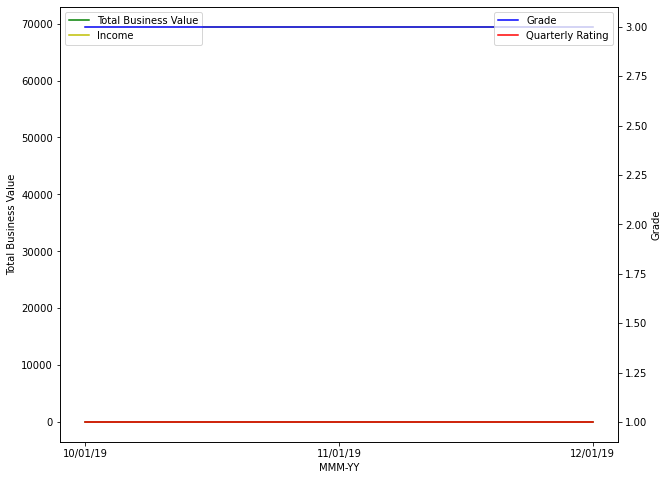

31 --> (6, 13)


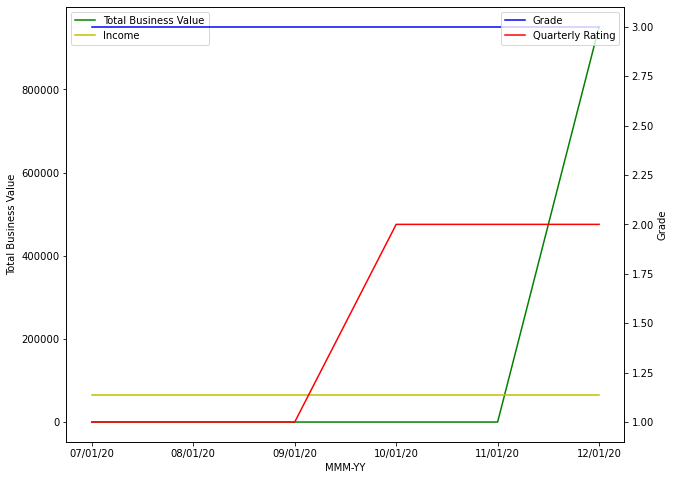

34 --> (4, 13)


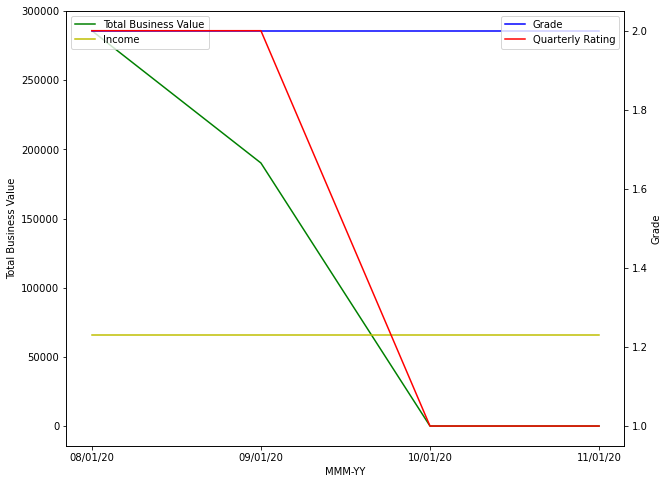

35 --> (3, 13)


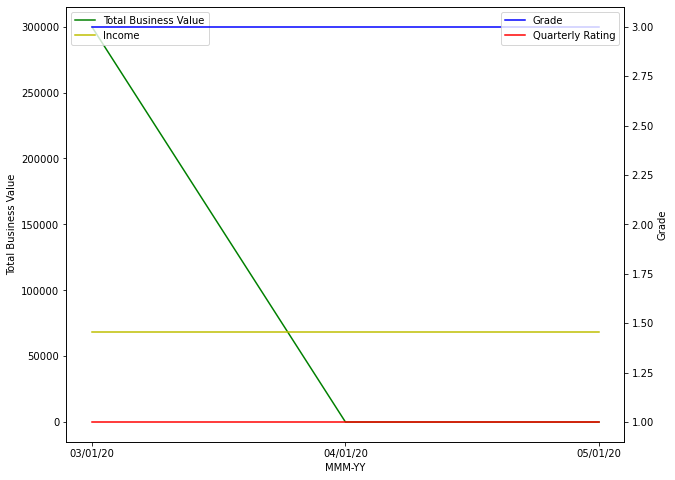

36 --> (14, 13)


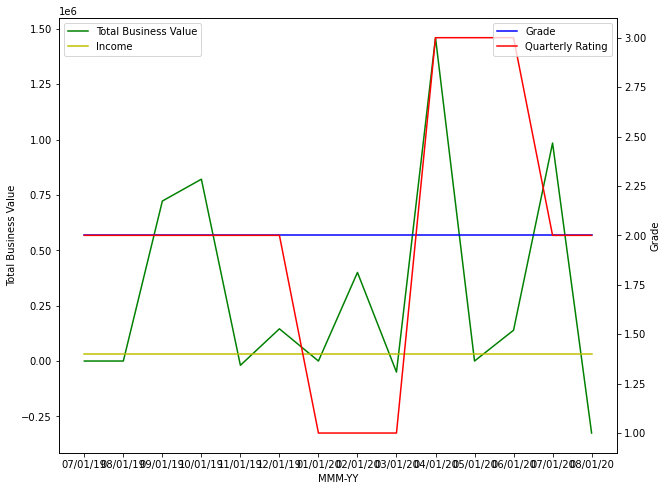

37 --> (6, 13)


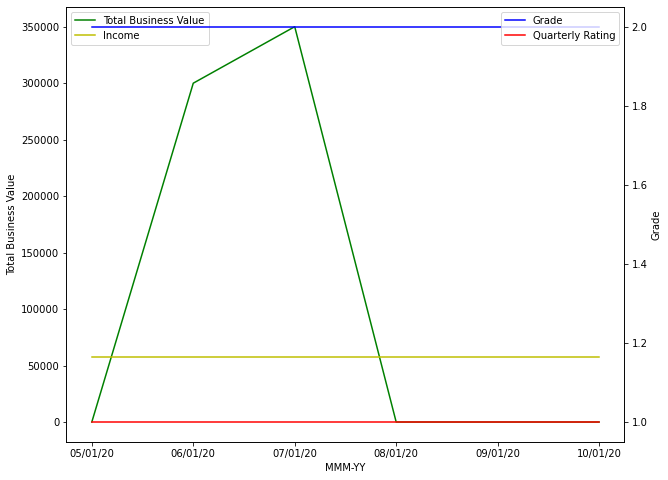

38 --> (4, 13)


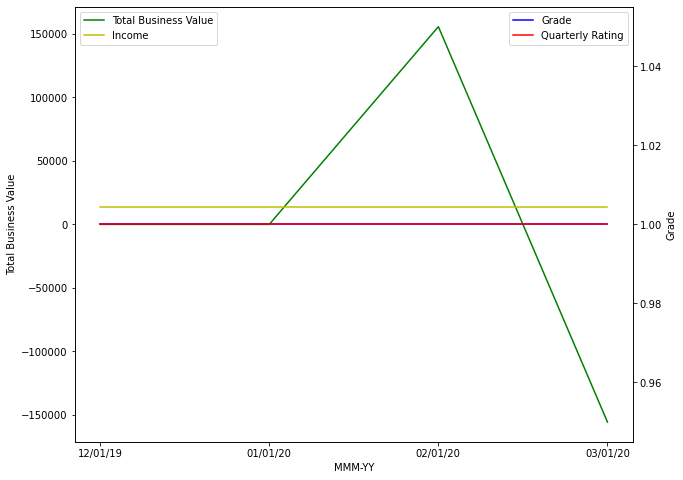

39 --> (5, 13)


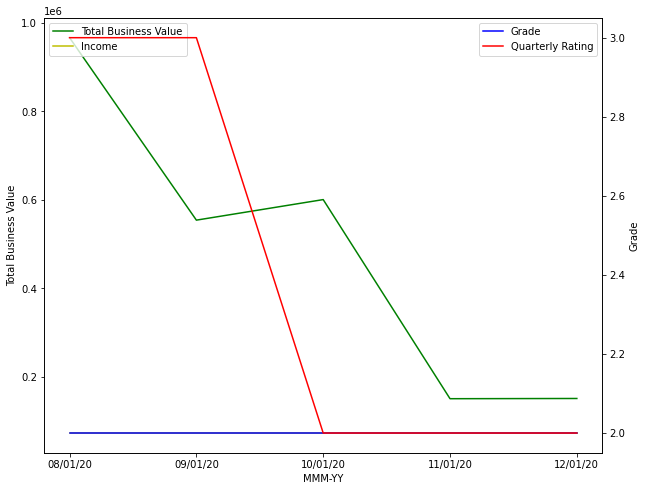

40 --> (4, 13)


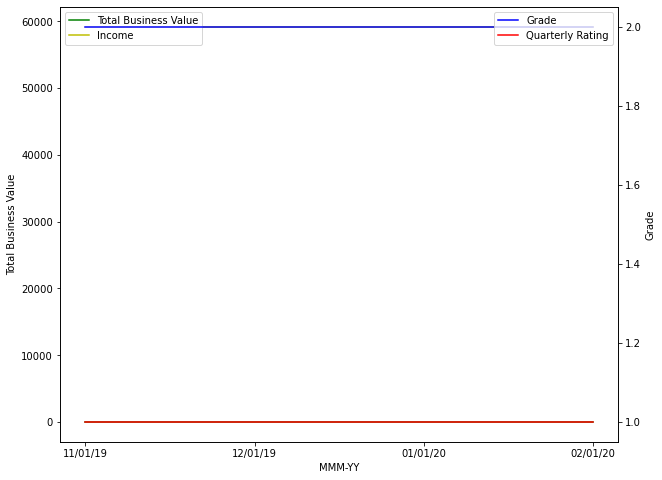

41 --> (18, 13)


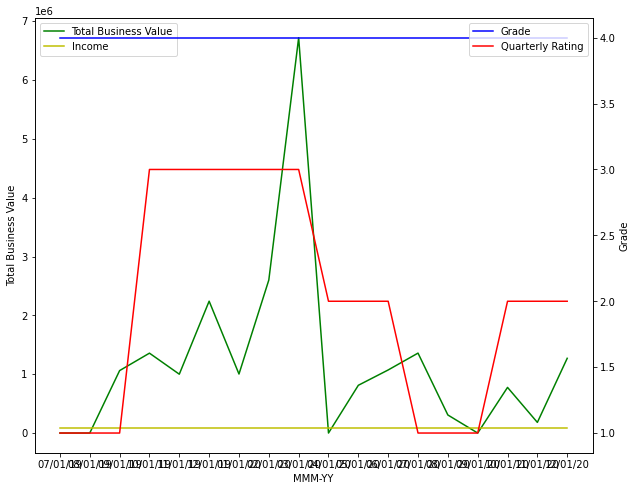

In [463]:
for iden in driver_ids:
    dfsub = df[df['Driver_ID'] == iden]
    print(iden, '-->',dfsub.shape)
    plt.figure(figsize=(10,8))
    sns.lineplot(x = dfsub['MMM-YY'],y = dfsub['Total Business Value'], color="g",label = 'Total Business Value')
    sns.lineplot(x = dfsub['MMM-YY'],y = dfsub['Income'], color="y",label = 'Income')
    plt.legend(fontsize=10,loc = 'upper left')
    ax2 = plt.twinx()
    sns.lineplot(x = dfsub['MMM-YY'],y = dfsub['Grade'], color="b", ax=ax2, label = 'Grade')
    sns.lineplot(x = dfsub['MMM-YY'],y = dfsub['Quarterly Rating'], color="r", ax=ax2, label = 'Quarterly Rating')
    plt.legend(fontsize=10,loc = 'upper right')
    plt.xticks(rotation=90)
    plt.show()
    

### as we see, Income, Grade dont vary, however, Quarterly ratings and Total Business value vary a lot. Lets try to build the dataframe for modeling the driver_ids. 

### 1. For churn, wherever LWD is present, we will say driver_id has churned (1) else not churned (0). If length of data after dropping nas remain same as of original length, we will say no-churn else churn

In [464]:
churnDic = {}
for iden in df['Driver_ID'].unique():
    dfsub = df[df['Driver_ID']==iden]
    if dfsub['LastWorkingDate'].isna().sum() == len(dfsub):
        churnDic[iden] = 0
    else:
        churnDic[iden] =1

### 2. To assign LWD to driver_id, we will use LWD after dropping NAs else we will assign Null

In [465]:
lwdDict = {}
for iden in df['Driver_ID'].unique():
    dfsub = df[df['Driver_ID']==iden]
    dfsub = dfsub.dropna()
    if len(dfsub) == 0 :
        lwdDict[iden] = np.nan
    else:
        lwdDict[iden] = dfsub['LastWorkingDate'].values[0]

### 3. To find the trend in Quarterly Rating and Total Business Value, we are fitting a liner line to see the trend. If the coefficient is positive,we will say with time, Quarterly Rating has increased for a given driver_id else it is assigned Zero. Same approach is taken for both Total Business Value and Quarterly Rating.

In [466]:
QuarterlyRatingTrendDict = {}
for iden in df['Driver_ID'].unique():
    dfsub = df[df['Driver_ID']==iden]
    dfsub['MMM-YY'] = pd.to_datetime(dfsub['MMM-YY'], format='%d/%m/%y')
    dfsub['MMM-YY']=dfsub['MMM-YY'].map(dt.datetime.toordinal)
    lr = LinearRegression()
    lr.fit(dfsub['MMM-YY'].values.reshape(-1, 1),dfsub['Quarterly Rating'].values.reshape(-1, 1))
    if lr.coef_ > 0 :
        QuarterlyRatingTrendDict[iden] = 1
    else:
        QuarterlyRatingTrendDict[iden] = 0
    

In [467]:
TotalBusinessValueTrendDict = {}
for iden in df['Driver_ID'].unique():
    dfsub = df[df['Driver_ID']==iden]
    dfsub['MMM-YY'] = pd.to_datetime(dfsub['MMM-YY'], format='%d/%m/%y')
    dfsub['MMM-YY']=dfsub['MMM-YY'].map(dt.datetime.toordinal)
    lr = LinearRegression()
    lr.fit(dfsub['MMM-YY'].values.reshape(-1, 1),dfsub['Total Business Value'].values.reshape(-1, 1))
    if lr.coef_ > 0 :
        TotalBusinessValueTrendDict[iden] = 1
    else:
        TotalBusinessValueTrendDict[iden] = 0
 

### Building the dataframe at each driver_id level: we created additional features -like : average values of Grade, Quarterly_Rating and Total_Business_Value. We are also including Trend for these columns (Quarterly_Rating and Total_Business_Value).

In [468]:
dfChurn = pd.DataFrame(data = {'Driver_ID': churnDic.keys(),
                                 'churn':churnDic.values(),
                                 'Age':df.groupby(['Driver_ID'])['Age'].mean().values,
                              'Gender':df.groupby(['Driver_ID'])['Gender'].mean().values,
                              'City':df.groupby(['Driver_ID'])['City'].agg(pd.Series.mode).values,
                              'Education_Level': df.groupby(['Driver_ID'])['Education_Level'].mean().values,
                              'Income_avg': df.groupby(['Driver_ID'])['Income'].mean().values,
                              'Joining_Designation': df.groupby(['Driver_ID'])['Joining Designation'].mean().values,
                              'Dateofjoining': df.groupby(['Driver_ID'])['Dateofjoining'].agg(pd.Series.mode),
                              'LastWorkingDate': lwdDict.values(),
                              'Grade_avg': df.groupby(['Driver_ID'])['Grade'].mean().values,
                              'Quarterly_Rating_avg': df.groupby(['Driver_ID'])['Quarterly Rating'].mean().values,
                              'Total_Business_Value_avg': df.groupby(['Driver_ID'])['Total Business Value'].mean().values,
                              'Quarterly_Rating_trend': QuarterlyRatingTrendDict.values(),
                              'Total_Business_Value_trend': TotalBusinessValueTrendDict.values()})


In [469]:
dfChurn.reset_index(drop=True,inplace=True)

In [470]:
dfChurn.shape

(2381, 15)

In [471]:
dfChurn.head()

,Driver_ID,churn,Age,Gender,City,Education_Level,Income_avg,Joining_Designation,Dateofjoining,LastWorkingDate,Grade_avg,Quarterly_Rating_avg,Total_Business_Value_avg,Quarterly_Rating_trend,Total_Business_Value_trend
0,1,1,28.0,0.0,C23,2,57387.0,1,24/12/18,03/11/19,1.0,2.0,571860.0,0,0
1,2,0,31.0,0.0,C7,2,67016.0,2,11/06/20,NaN,2.0,1.0,0.0,0,0
2,4,1,43.0,0.0,C13,2,65603.0,2,12/07/19,27/04/20,2.0,1.0,70000.0,0,1
3,5,1,29.0,0.0,C9,0,46368.0,1,01/09/19,03/07/19,1.0,1.0,40120.0,0,0
4,6,0,31.0,1.0,C11,1,78728.0,3,31/07/20,NaN,3.0,1.6,253000.0,1,1


In [472]:
dfChurn.dtypes

Driver_ID                       int64
churn                           int64
Age                           float64
Gender                        float64
City                           object
Education_Level                 int64
Income_avg                    float64
Joining_Designation             int64
Dateofjoining                  object
LastWorkingDate                object
Grade_avg                     float64
Quarterly_Rating_avg          float64
Total_Business_Value_avg      float64
Quarterly_Rating_trend          int64
Total_Business_Value_trend      int64
dtype: object

# Section 1.EDA

### Numerical columns

In [473]:
Xnum = dfChurn.select_dtypes(exclude = 'object')

 
column: Driver_ID
count    2381.000000
mean     1397.559009
std       806.161628
min         1.000000
25%       695.000000
50%      1400.000000
75%      2100.000000
max      2788.000000
Name: Driver_ID, dtype: float64
 


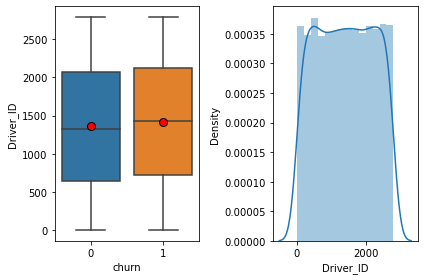

 
 
column: churn
count    2381.000000
mean        0.678706
std         0.467071
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64
 


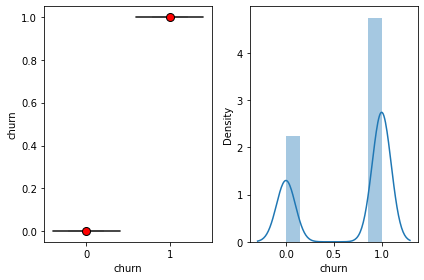

 
 
column: Age
count    2381.000000
mean       33.380768
std         5.870265
min        21.000000
25%        29.000000
50%        33.000000
75%        37.000000
max        58.000000
Name: Age, dtype: float64
 


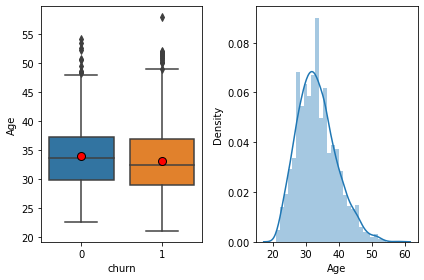

 
 
column: Gender
count    2381.000000
mean        0.410638
std         0.490822
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Gender, dtype: float64
 


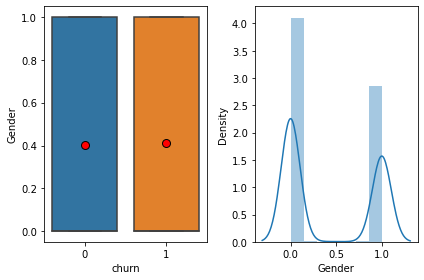

 
 
column: Education_Level
count    2381.00000
mean        1.00756
std         0.81629
min         0.00000
25%         0.00000
50%         1.00000
75%         2.00000
max         2.00000
Name: Education_Level, dtype: float64
 


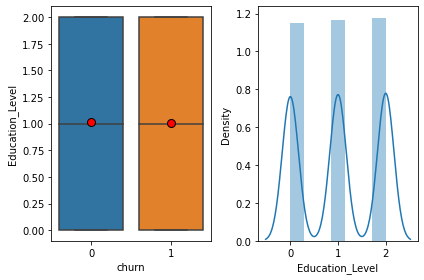

 
 
column: Income_avg
count      2381.000000
mean      59232.460484
std       28298.214012
min       10747.000000
25%       39104.000000
50%       55285.000000
75%       75835.000000
max      188418.000000
Name: Income_avg, dtype: float64
 


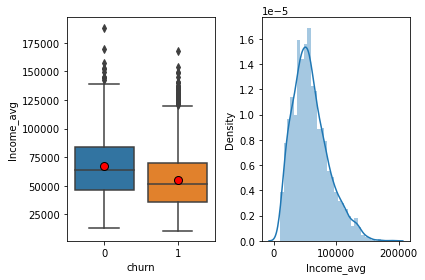

 
 
column: Joining_Designation
count    2381.000000
mean        1.820244
std         0.841433
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Joining_Designation, dtype: float64
 


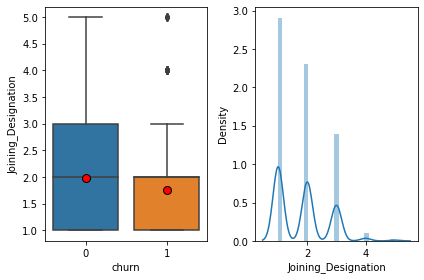

 
 
column: Grade_avg
count    2381.000000
mean        2.081713
std         0.932257
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: Grade_avg, dtype: float64
 


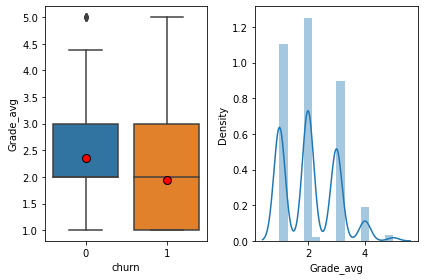

 
 
column: Quarterly_Rating_avg
count    2381.000000
mean        1.566304
std         0.719652
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Quarterly_Rating_avg, dtype: float64
 


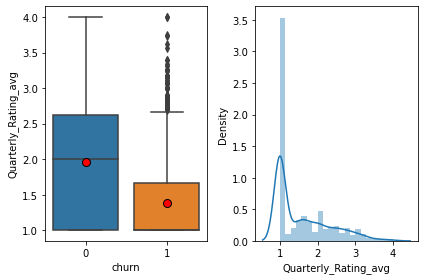

 
 
column: Total_Business_Value_avg
count    2.381000e+03
mean     3.120854e+05
std      4.495705e+05
min     -1.979329e+05
25%      0.000000e+00
50%      1.506244e+05
75%      4.294988e+05
max      3.972128e+06
Name: Total_Business_Value_avg, dtype: float64
 


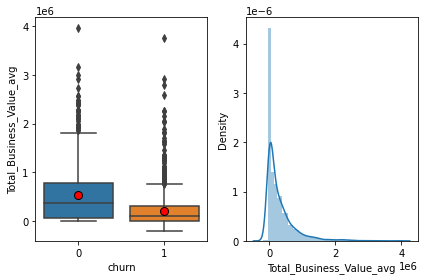

 
 
column: Quarterly_Rating_trend
count    2381.000000
mean        0.206636
std         0.404977
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Quarterly_Rating_trend, dtype: float64
 


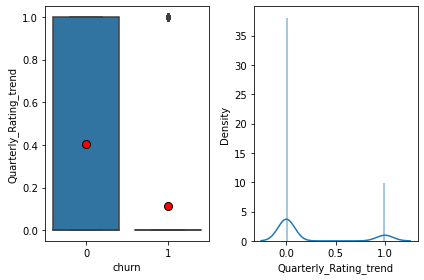

 
 
column: Total_Business_Value_trend
count    2381.000000
mean        0.351113
std         0.477418
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Total_Business_Value_trend, dtype: float64
 


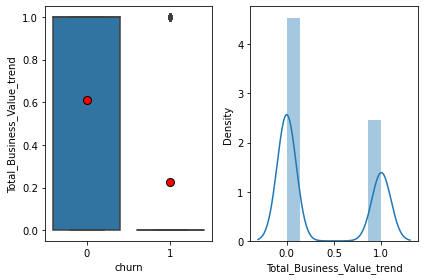

In [474]:
# plt.figure(figsize=(10,10))

for col in Xnum.columns:
    print(' ')
    print(f'column: {col}')
    print(dfChurn[col].describe())
    print(' ')
    fig, ax =plt.subplots(1,2)
    sns.boxplot(y = dfChurn[col], ax = ax[0], x= dfChurn['churn'] ,showmeans=True
               , meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
    sns.distplot(dfChurn[col], ax= ax[1])
    plt.tight_layout()
    plt.show()
    print(' ')

### Conclusion from above univariate analysis:
### 1. Age,Gender,Education level show no effect on churn behaviour
### 2. For rest, Income_avg', 'Joining_Designation', 'Dateofjoining', 'LastWorkingDate','Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg','Quarterly_Rating_trend', 'Total_Business_Value_trend - churn is observed more for lower values.

In [475]:
dfChurn.columns

Index(['Driver_ID', 'churn', 'Age', 'Gender', 'City', 'Education_Level',
       'Income_avg', 'Joining_Designation', 'Dateofjoining', 'LastWorkingDate',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg',
       'Quarterly_Rating_trend', 'Total_Business_Value_trend'],
      dtype='object')

### lets build correlation map for above features

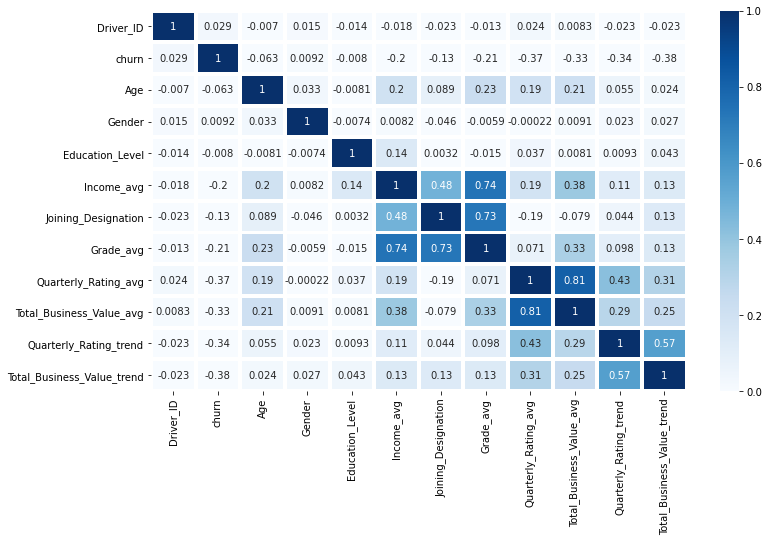

In [476]:
cormap = Xnum.corr(method='pearson')
plt.figure(figsize=(12,7))
sns.heatmap(cormap,annot=True,linewidth =3,cmap='Blues', vmax=0,vmin=1)
plt.show()

### Good correlation is observed between: JOining_designation & Income_avg, Grade_avg & Income_avg, JOining_designation & Grade_average, Total_business_value_avg & Quarterly_rating_avg and trend values between Total_business_value and Total_business_value. 

### city

In [477]:
dfChurn['City'].describe()

count     2381
unique      29
top        C20
freq       152
Name: City, dtype: object

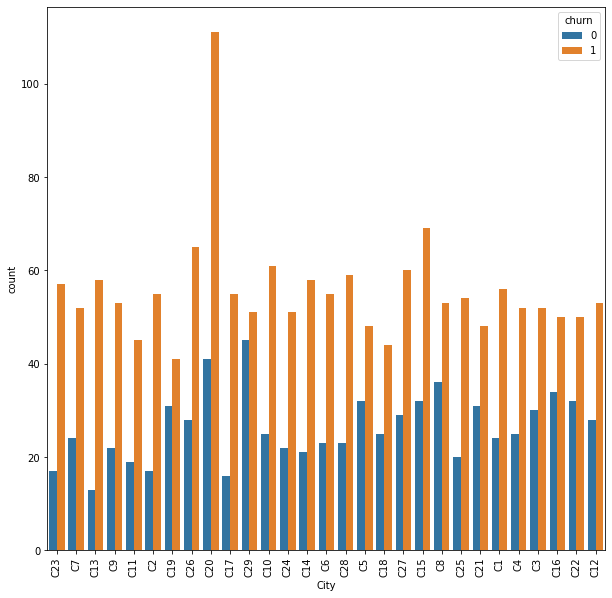

In [478]:
plt.figure(figsize=(10,10))
sns.countplot(dfChurn['City'], hue = dfChurn['churn'])
plt.xticks(rotation=90)
plt.show()

### Churn is observed more for city C20, C8 and C26.

# Bivariate analysis

## lets start with bivariate plots for numerical features 

In [479]:
dfChurn.columns

Index(['Driver_ID', 'churn', 'Age', 'Gender', 'City', 'Education_Level',
       'Income_avg', 'Joining_Designation', 'Dateofjoining', 'LastWorkingDate',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg',
       'Quarterly_Rating_trend', 'Total_Business_Value_trend'],
      dtype='object')

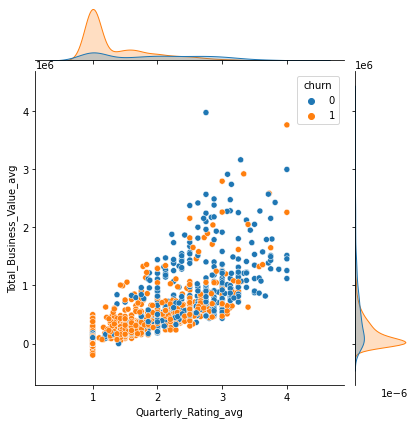

In [480]:
sns.jointplot(x = dfChurn['Quarterly_Rating_avg'], y = dfChurn['Total_Business_Value_avg'], hue=dfChurn['churn'])

### low average Quarterly_Rating implies low Total Business Value and higher churn for both

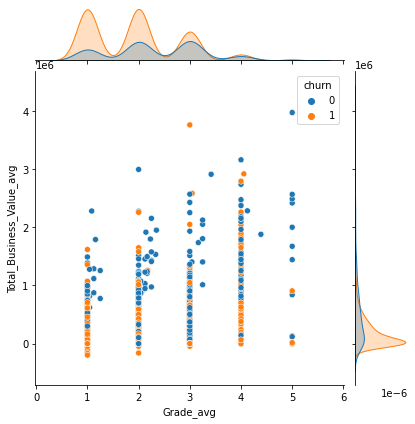

In [481]:
sns.jointplot(x = dfChurn['Grade_avg'], y = dfChurn['Total_Business_Value_avg'], hue=dfChurn['churn'])

### low Total Business Value and low Grade average shows higher churn

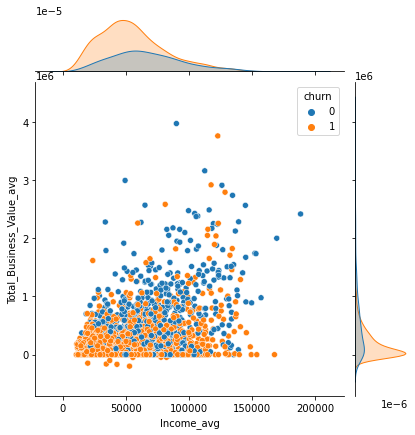

In [482]:
sns.jointplot(x = dfChurn['Income_avg'], y = dfChurn['Total_Business_Value_avg'], hue=dfChurn['churn'])

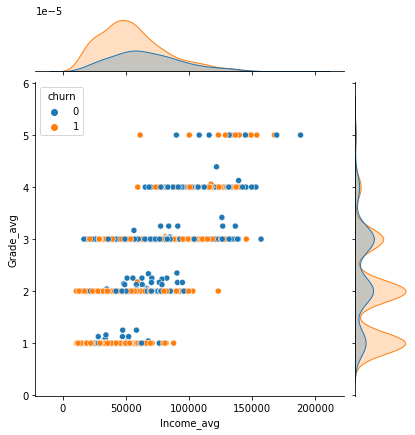

In [483]:
sns.jointplot(x = dfChurn['Income_avg'], y = dfChurn['Grade_avg'], hue=dfChurn['churn'])

In [484]:
dfChurn.columns

Index(['Driver_ID', 'churn', 'Age', 'Gender', 'City', 'Education_Level',
       'Income_avg', 'Joining_Designation', 'Dateofjoining', 'LastWorkingDate',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg',
       'Quarterly_Rating_trend', 'Total_Business_Value_trend'],
      dtype='object')

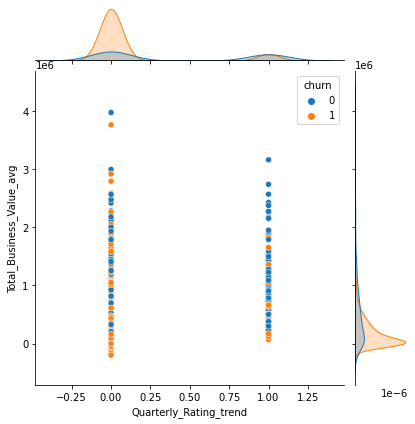

In [485]:
sns.jointplot(x = dfChurn['Quarterly_Rating_trend'], y = dfChurn['Total_Business_Value_avg'], hue=dfChurn['churn'])


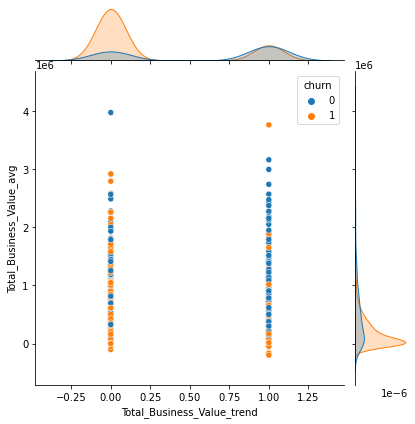

In [486]:
sns.jointplot(x = dfChurn['Total_Business_Value_trend'], y = dfChurn['Total_Business_Value_avg'], hue=dfChurn['churn'])



### Similar observation as above (lower values imply more churn)

# Section2: focuses on model building and metric discussion

### Among all the features built above, we will use different combinations of features based on higher evaluation metrics. Here, we see the the y values or target is not very well balanced. So, in that case, we will use f1 score for out evaluation. Also, with f1 score, we will focus more on Recall and try to optimize for it as we want to have lower values of FN. Here, FN imply there is a churn but we could not identify. On the otherhand, FP imply, we are falsely identifying that there will be churn which is not very concerning here.

In [487]:
y = dfChurn[['churn']]
X = dfChurn.drop(['churn'],axis=1)


In [488]:
y.value_counts(normalize=True)*100

churn
1        67.870643
0        32.129357
dtype: float64

In [489]:
dfChurn.columns

Index(['Driver_ID', 'churn', 'Age', 'Gender', 'City', 'Education_Level',
       'Income_avg', 'Joining_Designation', 'Dateofjoining', 'LastWorkingDate',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg',
       'Quarterly_Rating_trend', 'Total_Business_Value_trend'],
      dtype='object')

In [490]:
cols_to_use1 = ['Age', 'Gender', 'Education_Level',
       'Income_avg', 'Joining_Designation',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg',
       'Quarterly_Rating_trend', 'Total_Business_Value_trend']

In [491]:
cols_to_use2 = ['Age', 'Gender', 'Education_Level',
       'Income_avg', 'Joining_Designation',
       'Grade_avg', 
       'Quarterly_Rating_trend', 'Total_Business_Value_trend']

In [492]:
cols_to_use = ['Age', 'Gender', 'Education_Level',
       'Income_avg', 'Joining_Designation',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg']

In [493]:
Xmodel = X[cols_to_use]

In [494]:
Xmodel.shape, y.shape

((2381, 8), (2381, 1))

In [495]:
Xmodel.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [496]:
def calc_vif(X):
    
 # Calculating the VIF
    vif = pd.DataFrame()
    vif['Feature'] = Xmodel.columns
    vif['VIF'] = [variance_inflation_factor(Xmodel.values, i) for i in range(Xmodel.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif
calc_vif(Xmodel)

,Feature,VIF
5,Grade_avg,29.69
0,Age,17.59
6,Quarterly_Rating_avg,16.51
4,Joining_Designation,16.40
3,Income_avg,13.13
7,Total_Business_Value_avg,5.81
2,Education_Level,2.61
1,Gender,1.69


### we will use different combinations of features based upon f1 score.

### splitting dataset into train/test/validation

In [497]:
X_train, X_test, y_train, y_test = train_test_split(Xmodel, y, test_size=0.2, random_state=4)

In [498]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1904, 8), (477, 8), (1904, 1), (477, 1))

### we will not create separate valaidation set due to lower data points

In [499]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [500]:
lr = LogisticRegression() # C = 1, lambda = 1
lr.fit(X_train, y_train)
cv_acc_results = cross_validate(lr, X_train, y_train, cv = 5, scoring = 'f1', return_train_score = True, )

print(f"K-Fold f1 score Mean: Train: {cv_acc_results['train_score'].mean().round(3)*100} Validation: {cv_acc_results['test_score'].mean().round(3)*100}")

K-Fold f1 score Mean: Train: 82.6 Validation: 82.5


### 82% score with Logistic regression and cross validation show almost no overfitting.

# Decision Tree

In [501]:
tree_clf = DecisionTreeClassifier(random_state=7, max_depth = 7, )
cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = 5, scoring = 'f1', return_train_score = True, )

print(f"K-Fold f1-score Mean: Train: {cv_acc_results['train_score'].mean().round(3)*100} Validation: {cv_acc_results['test_score'].mean().round(3)*100}")

K-Fold f1-score Mean: Train: 86.8 Validation: 79.80000000000001


### Higher difference between train and validation scores show overfitting.

# RandomForest 

In [502]:
tree_clf = RandomForestClassifier(random_state=7, max_depth = 7, n_estimators= 100 )
cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = 5, scoring = 'f1', return_train_score = True)

print(f"K-Fold f1-score Mean: Train: {cv_acc_results['train_score'].mean().round(3)*100} Validation: {cv_acc_results['test_score'].mean().round(3)*100}")



K-Fold f1-score Mean: Train: 87.9 Validation: 82.89999999999999


### model has improved with RF and shows less overfitting. Lets see with other algorithms as well

# GBDT

In [503]:
tree_clf = GradientBoostingClassifier(random_state=7, max_depth = 4, n_estimators= 150, learning_rate = 0.1 )
cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = 3, scoring = 'f1', return_train_score = True)

print(f"K-Fold f1-score Mean: Train: {cv_acc_results['train_score'].mean().round(3)*100} Validation: {cv_acc_results['test_score'].mean().round(3)*100}")


K-Fold f1-score Mean: Train: 93.89999999999999 Validation: 81.0


### model performance has improved but shows overfitting with Gradient boosting

# XGBoost

In [504]:
params = {
        'learning_rate': [0.1, 0.5, 0.8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
# xgb = XGBClassifier(n_estimators=100, objective='binary:logistic', num_class=2, silent=True)
xgb = XGBClassifier()

# xgb = XGBClassifier(n_estimators=100, objective='multi:softmax', num_class=20, subsample=0.8, max_depth=4, learning_rate=0.2, colsample_bytree=0.8, silent=True)
# xgb.fit(X_train, Y_train)


In [505]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='f1', n_jobs=-1, cv=3, verbose=1, random_state=1001 )


start = dt.datetime.now()
random_search.fit(X_train, y_train.values)
end = dt.datetime.now()


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [506]:
print('Best hyperparameters:')
print(random_search.best_params_)

Best hyperparameters:
{'subsample': 1.0, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [507]:
best_xgb = XGBClassifier(n_estimators=100, subsample=1, max_depth=3, learning_rate=0.1, colsample_bytree=1.0, silent=True)
best_xgb.fit(X_train, y_train)


[22:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [508]:
print(f"Time taken for training : {end - start}\nTraining accuracy:{best_xgb.score(X_train, y_train)}\nTest Accuracy: {best_xgb.score(X_test, y_test)}")


Time taken for training : 0:00:00.548451
Training accuracy:0.792016806722689
Test Accuracy: 0.790356394129979


In [509]:
cv_acc_results = cross_validate(best_xgb, X_train, y_train, cv = 3, scoring = 'f1', return_train_score = True)
print(f"K-Fold fi-score Mean: Train: {cv_acc_results['train_score'].mean().round(3)*100} Validation: {cv_acc_results['test_score'].mean().round(3)*100}")


[22:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:07:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

K-Fold fi-score Mean: Train: 87.2 Validation: 82.89999999999999


### with XGBoost, the difference between train and validation accuracy has reduced which shows less overfitting.Hence, we will go ahead with this model on prediction on test set and calculating precision & recall.

In [510]:
print(precision_score(y_test, best_xgb.predict(X_test)))
print(recall_score(y_test, best_xgb.predict(X_test)))

0.806282722513089
0.9221556886227545


[0.06852658 0.02563913 0.08055445 0.06152828 0.19580701 0.13711302
 0.33714658 0.09368487]


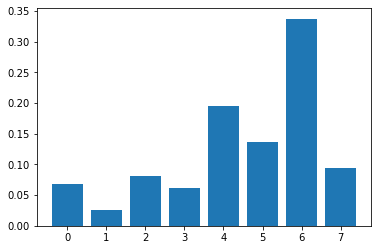

In [511]:
print(best_xgb.feature_importances_)

plt.bar(range(len(best_xgb.feature_importances_)), best_xgb.feature_importances_)
plt.show()

In [512]:
Xmodel.columns

Index(['Age', 'Gender', 'Education_Level', 'Income_avg', 'Joining_Designation',
       'Grade_avg', 'Quarterly_Rating_avg', 'Total_Business_Value_avg'],
      dtype='object')

### important features are 'Quarterly_Rating_avg', followed by Joining_Designation and then Grade

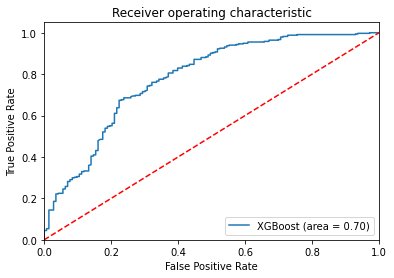

In [513]:
xgb_roc_auc = roc_auc_score(y_test, best_xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

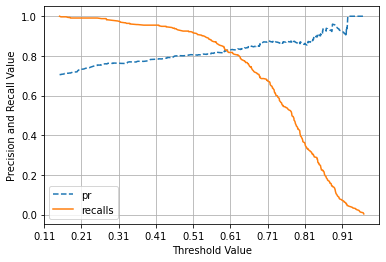

In [514]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, best_xgb.predict_proba(X_test)[:,1])

    threshold_boundary = thresholds.shape[0]
 # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='pr')
 # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, best_xgb.predict_proba(X_test)[:,1])

In [515]:
predictions = best_xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.48      0.58       143
           1       0.81      0.92      0.86       334

    accuracy                           0.79       477
   macro avg       0.77      0.70      0.72       477
weighted avg       0.78      0.79      0.78       477



# Section 3: Insights and Recommendations

### 1. Quarterly rating comes out to be very important feature while deciding the churn. We should not spend much on retaining drivers which shows a decling ratings. On the other hand, we should try to give more offers to drivers who are consistently getting higher ratings. 
### 2. Early indication of churn could be - Income_avg', 'Joining_Designation'. Drivers who joined at lower values of these show more churn behaviour than rest. 
### 3. Drivers belonging to City C20 show more behaviour of churn. We can have targetted schemes for these drivers to roll-up more. On the otherhand, we may not want to spend more on acuquring drivers from these regions. 
### 4. Higher quarterly rating may not always lead to higher Total Business Value. We can have targetted schemes for these drivers as higher rating may not lead to Churn.

In [516]:
### peer learning ####

1

In [331]:
y_train.shape, X_train.shape

((1904, 1), (1904, 8))